In [17]:
'''
This program calculates the time evolution of a single particle in a driven superlattice embedded
in a harmonic oscillator.

By rescaling everything by the hopping amplitude J1, we have 3 free system parameters:
                - Hopping amplitude J2
                - Harmonic oscillator amplitude A
                - Alternating energy offset Delta
                - Driving amplitude V0
                - Driving frequency w
                
Note that if the harmonic oscillator is supposed to be located in the middle of the lattice, the amount
of lattice sites considered 'n' has to be an odd number!
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from scipy.fft import fft, fftfreq
from scipy.special import jv
import scipy.optimize as optimize

import numpy as np
from scipy import linalg

# Normalisation function
def norm(psi):
    norm2 = 0
    for element in psi:
        norm2 += np.abs(element)
    return psi/np.sqrt(norm2)

# Gauss function for initial condition (well localised state for s<<1)
def gauss(x,m,s):
    return np.exp(-(x-m)**2/(2*s**2))

# Convert physical index to computational index
def comp(n,x):
    return int(n/2)+x

# Convert computational index to physical index
def phys(n,i):
    return -int(n/2)+i

# Function that constructs explicit matrix representation of Hamiltonian at a given instant in time
def Hamilton(t_T,j1,j2,a,v0,wT,phi,delta,n):

    Hamilton = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            if i==j:
                Hamilton[i,j] = a*phys(n,j)**2
                if i%2 == 0:
                    Hamilton[i,j] += v0/2*np.cos(wT*t_T+phi)-delta
                if i%2 == 1:
                    Hamilton[i,j] += -v0/2*np.cos(wT*t_T+phi)+delta
            if np.abs(i-j)==1:
                if (i+j)%4==1:
                    Hamilton[i,j] = -j1   #j2 before
                if (i+j)%4==3:
                    Hamilton[i,j] = -j2 
    return Hamilton
  
# Calculate time evolution using the unitary time evolution operator 
def SEQ(j1,j2,a,v0,wT,phi,dt_T,cycles,start,s=1e-15,delta=0,n=43):
    
    # Time array
    t_T = np.arange(0,cycles,dt_T)
    m = len(t_T)
    
    # Wave function and initial condition
    psi = np.zeros((n,m),dtype=complex)
    #psi[comp(start),0] = 1
    
    # Gaussian distribution as initial condition (s<<1 -> delta peak)
    for i in range(n):
        psi[i,0] = gauss(i,comp(n,start),s)
    
    
    psi[:,0] = norm(psi[:,0])
    
    # Hopping observable
    hopping = np.zeros((n-1,m))

    for i in range(m-1):

        U = linalg.expm(-1j*dt_T*Hamilton(t_T[i],j1,j2,a,v0,wT,phi,delta,n))
        psi[:,i+1] = np.matmul(U,psi[:,i])

        for j in range(n-1):
            hopping[j,i] += np.real(np.conj(psi[j+1,i])*psi[j,i]+psi[j+1,i]*np.conj(psi[j,i]))

    # Approximate last element of hopping array
    for i in range(n-1):
        
        hopping[i,m-1] += np.real(np.conj(psi[i+1,m-1])*psi[i,m-1]+np.conj(psi[i,m-1])*psi[i+1,m-1])
   
    density = np.abs(psi)**2
    
    # Consistency: Normalization should be conserved
    consistency = np.zeros(m)
    for i in range(m):
        for j in range(n-1):
            consistency[i] += np.abs(psi[j,i])**2
            
    return t_T, density, hopping, consistency 

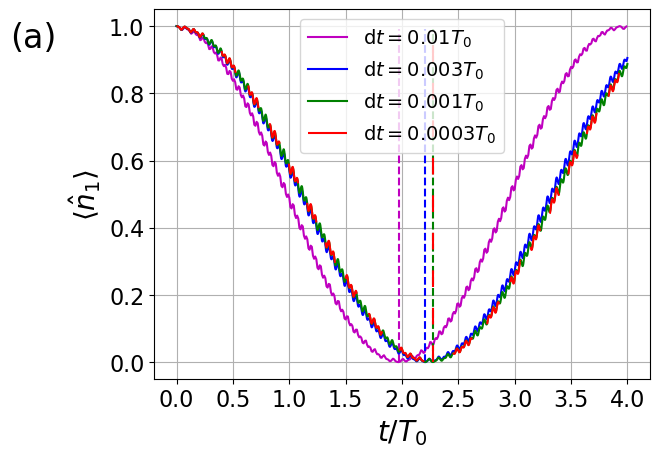

In [2]:
##########################################
# Part1: Choose appropriate stepsize dwt #
##########################################

# Function that finds first local minimum of an array
def find_min(ar):
    n = len(ar)
    peak_pos = 0
    peak = 0
    for i in range(1,n-1):
        
        if ar[i-1] > ar[i] and ar[i+1] > ar[i] and ar[i] < 1e-3:
            peak_pos = i
            peak = ar[i]
            break
    return peak_pos, peak
 
critical = 2.408
freq0 = 50*np.pi

n = 2
J2_J1 = 0
A_J1 = 0
V0_J1 = 50
hw_J1 = 25

# Parameters in units of h/T_0 (h: Reduced Planck constant, T_0: Time period of two site
# oscillations of local density for no drive and no imbalance)
j1 = np.pi
j2 = np.pi*J2_J1
a = np.pi*A_J1
wT = np.pi*hw_J1
v0 = V0_J1*np.pi

dt_T = np.array([0.01,0.003,0.001,0.0003])
wall = np.arange(0,1,0.01)
p = len(wall)

# Plotting expectation value of number operators and compare convergence
#plt.figure(figsize=(20,10))
fig = plt.figure()
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$t/T_0$',fontsize=20)
plt.ylabel(r'$\langle\hat{n}_1\rangle$',fontsize=20)

#plt.title(r'$J_1=%.1f \hbar/T, J_2=%.1f \hbar/T, V_0=%.1f \hbar/T, A=%.1f \hbar/T $' %(j1,j2,v0,a),fontsize=32)
c = ['m','b','green','r','pink']
linestyle1 = ['-','-','-',(0,(20,20)),(0,(10,10))]
linestyle2 = ['--','--','--',(0,(8,10)),(0,(4,8))]

#plt.ylim(0,1.2)
for i in range(len(dt_T)):
    measure = dt_T[i]
    ret = SEQ(j1,j2,a,v0,wT,phi=0,dt_T=measure,cycles=4,start=0,n=n)
    t_T, density, hopping, consistency = ret
    state0 = density[comp(n,0),:]
    '''
    start_zoom = int(0.490/measure)
    end_zoom = int(0.509/measure)
    t_T_zoom = t_T[start_zoom:end_zoom]
    state0_zoom = state0[start_zoom:end_zoom]
    '''
    plt.plot(t_T,state0,label='$\mathrm{d}t = %s T_0$' % dt_T[i],linewidth=1.5,alpha=1,c=c[i],linestyle=linestyle1[i])
    #plt.plot(t_T,state0+0.1*np.linspace(0,1,len(state0)),c=c[i])
    root = measure*np.argmin(state0+0.001*np.linspace(0,1,len(state0)))
    plt.plot(root*np.ones(p),wall,c=c[i],alpha=1,linestyle=linestyle2[i],linewidth=1.5)
    
fig.text(-0.1,0.8,'(a)',fontsize=24)
plt.legend(loc='best',fontsize=14)
plt.show()

Done with dt/T=0.0100
Done with dt/T=0.0030
Done with dt/T=0.0010
Done with dt/T=0.0003


Text(-0.1, 0.8, '(b)')

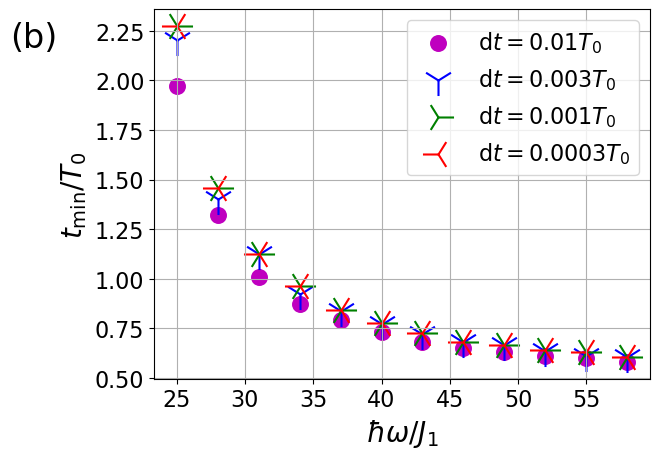

In [3]:
# Quantify the convergence of our program
critical = 2.408
sites = 2
J2_J1 = 0
A_J1 = 0
V0_J1 = 50

# Parameters in units of h/T_0 (h: Reduced Planck constant, T_0: Time period of undriven
# two site oscillations of local density for no drive and no imbalance)
j1 = np.pi
j2 = np.pi*J2_J1
a = np.pi*A_J1

# Convergence with respect to driving frequency
freq0 = 50*np.pi
v0 = V0_J1*np.pi
dt_T = np.array([0.01,0.003,0.001,0.0003])
hw_J1 = np.arange(25,60,3)
wT = np.pi*hw_J1
n = len(dt_T)
m = len(hw_J1)

max_ar = np.empty((n,m))
for i in range(n):   # dt_t loop 
    for j in range(m):   # hw_J1 loop
        measure = dt_T[i]
        ret = SEQ(j1,j2,a,v0,wT[j],phi=0,dt_T=dt_T[i],cycles=2.4,start=0,n=sites)
        t_T, density, hopping, consistency = ret
        state0 = density[comp(sites,0),:]
        peak_pos = np.argmin(state0+0.001*np.linspace(0,1,len(state0)))
        peak_pos *= measure
        max_ar[i,j] = peak_pos
    print('Done with dt/T=%.4f' % dt_T[i])
    
marker = ['.', '1', '4', '3','2']
c = ['m','b','g','r','c']

#plt.figure(figsize=(12,10))
fig = plt.figure()
plt.grid(True)
plt.xlabel(r'$\hbar\omega/J_1$',fontsize=20)
plt.ylabel('$t_\mathrm{min}/T_0$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

for i in range(n):
    plt.scatter(hw_J1,max_ar[i,:],c=c[i],label=r'$\mathrm{d}t = %s T_0$' % dt_T[i],marker=marker[i], s=500)
plt.legend(loc='best',fontsize=16)
fig.text(-0.1,0.8,'(b)',fontsize=24)


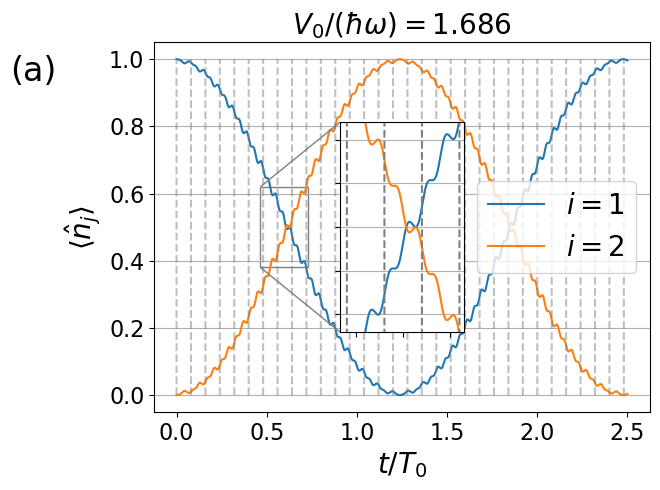

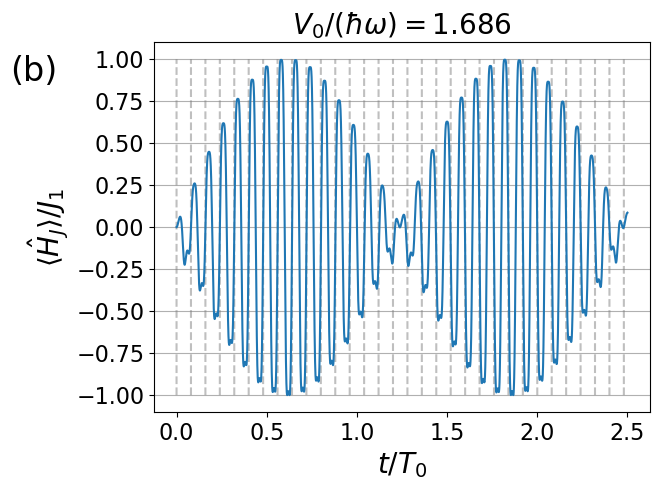

In [4]:
#################################################
# Part2: Two site oscillations of local density #
#################################################

n = 2    # Two sites
critical = 2.408    # First root of zeroth Bessel function

J2_J1 = 0
A_J1 = 0
hw_J1 = 25
V0_J1 = 0.722*hw_J1
Delta_J1 = 0

# Parameters in units of h/T_0 (h: Reduced Planck constant, T_0: Time period of undriven
# two site oscillations of local density for no drive and no imbalance)
j1 = np.pi
j2 = np.pi*J2_J1
a = np.pi*A_J1
wT = np.pi*hw_J1
v0 = 0.7*critical*wT
delta = np.pi*Delta_J1

ret = SEQ(j1,j2,a,v0,wT,phi=0,dt_T=0.0001,cycles=2.5,start=0,n=n,delta=delta)
t_T, density, hopping, consistency = ret
m = len(t_T)

a = np.arange(2*np.pi/wT,6.2,2*np.pi/wT)
spot = 1000
y = np.linspace(0,1,spot)
y2 = np.linspace(-1,1,spot)
x = np.ones(1000)

# Plotting local density
fig, ax = plt.subplots()
plt.grid(axis='y')
plt.xlabel(r'$t/T_0$',fontsize=20)
plt.ylabel(r'$\langle\hat{n}_j\rangle$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(r'$V_0/(\hbar\omega)=%.3f$' %(v0/np.pi/hw_J1),fontsize=20)
plt.plot(t_T,density[comp(n,0),:],label='$i=1$')
plt.plot(t_T,density[comp(n,-1),:],label='$i=2$')#,linestyle='--')
plt.legend(loc='right',fontsize=20)

# Dashed lines for full cycles of driving
cyc = np.arange(0,2.5,2/hw_J1)
dashx = np.ones(2000)
dashy = np.linspace(0,1,2000)

for el in cyc:
    plt.plot(el*dashx,dashy,linestyle='--',c='grey',alpha=0.5)

axins = zoomed_inset_axes(ax, 2.6, loc=10) # zoom = 6
axins.plot(t_T,density[comp(n,-1),:])
axins.plot(t_T,density[comp(n,0),:])
for i in range(len(cyc)):
    axins.plot(cyc[i]*dashx,dashy,c='grey',linestyle='--',alpha=1)

axins.set_xlim(0.465, 0.73) # Limit the region for zoom
axins.set_ylim(0.38, 0.62)

plt.xticks(visible=False) 
plt.yticks(visible=False)
plt.grid(axis='y')

fig.text(-0.1,0.8,'(a)',fontsize=24)
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
plt.show()

# Plotting expectation value of hopping term
fig,ax = plt.subplots()
plt.grid(axis='y')
plt.xlabel(r'$t/T_0$',fontsize=20)
plt.ylabel(r'$\langle\hat{H}_J\rangle/J_1$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(r'$V_0/(\hbar\omega)=%.3f$' %(v0/np.pi/hw_J1),fontsize=20)

# Dashed lines for full cycles of driving
cyc = np.arange(0,2.5,2/hw_J1)
dashx = np.ones(2000)
dashy = np.linspace(-1,1,2000)

for el in cyc:
    plt.plot(el*dashx,dashy,linestyle='--',c='grey',alpha=0.5)
    
plt.plot(t_T,hopping[comp(n,-1),:])
fig.text(-0.1,0.8,'(b)',fontsize=24)
plt.show()

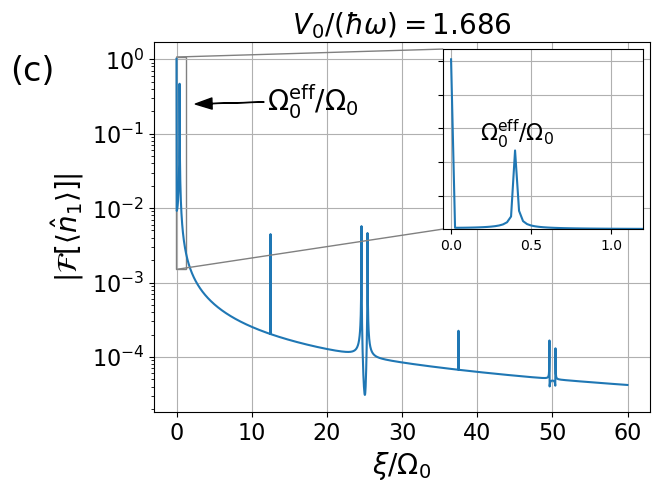

In [5]:
# Fourier transformation of local density oscillations

# Function that returns (angular) frequencies of input signal
def fft_clean(signal):
    m = len(signal)
    freq = fftfreq(m)
    mask = freq >= 0
    amp = 2*np.abs(fft(signal/m))
    freq = m*freq[mask]
    amp = amp[mask]
    return freq, amp

critical = 2.408    # First root of zeroth Bessel function

cycles = 40
dt_T = 0.0002

J2_J1 = 0
A_J1 = 0
hw_J1 = 25
V0_J1 = 18.1
Delta_J1 = 0

# Parameters in units of h/T_0 (h: Reduced Planck constant, T_0: Time period of undriven
# two site oscillations of local density for no drive and no imbalance)
j1 = np.pi
j2 = np.pi*J2_J1
a = np.pi*A_J1
wT = np.pi*hw_J1
delta = np.pi*Delta_J1
v0 = 0.7*critical*wT

ret = SGL(j1,j2,a,v0,wT,phi=0,dt_T=dt_T,cycles=cycles,start=0,s=1e-15,n=2,delta=delta)
t_T, density, hopping, consistency = ret
m = len(t_T)
freq, amp = fft_clean(density[comp(2,0),:])

'''
with open('ENTER FILEPATH HERE', 'w') as file:
    file.write('#The Parameters read: dt/T=%.5f, Cycles=%.3f, hw/J1=%.3f, V0/J1=%.3f, Delta/J1=%.3f\n' % (dt_T,cycles,hw_J1,V0_J1,Delta_J1))
    file.write('#Omega/Omega0 FourierTrafo\n')
    for i in range(len(freq)):
        file.write('%s %s\n' % (freq[i]/cycles, amp[i]))
'''

# Plotting calculated spectrum with logarithmic y-scaling
fig, ax = plt.subplots()
ax.plot(freq[0:int(cycles*60)]/cycles,amp[0:int(cycles*60)])
ax.grid()
plt.yscale('log')
plt.xlabel(r'$\xi/\Omega_0$',fontsize=20)
plt.ylabel(r'$|\mathcal{F} [\langle\hat{n}_1\rangle]|$',fontsize=20)
plt.title(r'$V_0/(\hbar\omega)=%.3f$' % (v0/np.pi*1/hw_J1),fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.annotate(r'$\Omega^\mathrm{eff}_0/\Omega_0$',fontsize=20, xy=(2.5,2.5e-1), xytext=(12,2e-1),arrowprops=dict(facecolor='black',width=0.1,headwidth=8))
fig.text(-0.1,0.8,'(c)',fontsize=24)
axins = inset_axes(ax,2,1.8,loc=1)
axins.plot(freq[::]/cycles,amp[::])
axins.set_xlim(-0.05,1.2)
axins.set_ylim(0.0015,1.07)
plt.text(0.18,0.52,r'$\Omega_0^\mathrm{eff}/\Omega_0$',fontsize=16)
plt.xticks(visible=True)
plt.yticks(visible=False)
plt.grid()
mark_inset(ax,axins,loc1=2,loc2=3,fc='none',ec='0.5')
plt.show()

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


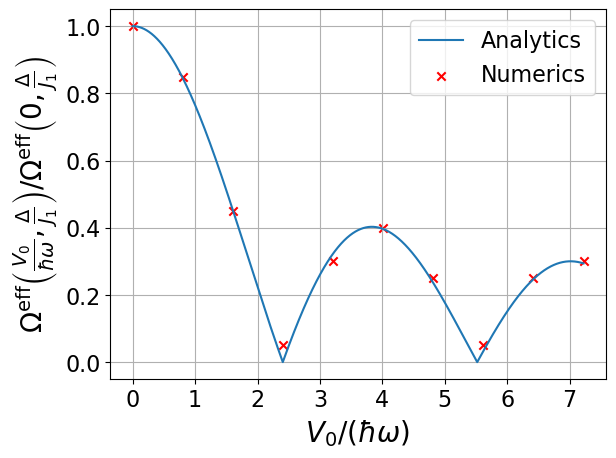

"\n#with open('ENTER FILEPATH HERE', 'w') as file:\n    file.write('# One particle two site hopping with dt/T=%.5f, cycles=%.1f, J2/J1=%.1f,hw/J1=%.1f,A/J1=%.1f\n' % (dt_T, cycles, J2_J1, hw_J1, A_J1))\n    file.write('# V0/wT Omega / T^(-1)\n')\n    for i in range(len(freqs)):\n        file.write('%s %s\n' % (v0[i]/wT, freqs[i]/cycles))\n"

In [8]:
# We get good results for:
# n=2, cycles=20, dt_T=0.0002,J2_J1=0, A_J1=0, hw_J1=50, Delta_J1=0.4, 0<v0<3*critical*wT

# look at dependency of effective frequency of local density on the ration of the driving parmaters

# load data calculated earlier – if you need the data, just let me know!
'''
# loading data for Delta=0
data_D0 = np.loadtxt('../../Data/OneParticle/Oscillations/Frequency_OneParticle_n2_cycles20_dt0_0002_J20_A0_hw50_Delta0.txt')
xdata_D0 = data_D0[:,0]
ydata_D0 = data_D0[:,1]

# loading data for Delta=0.4
data_D04 = np.loadtxt('../../Data/OneParticle/Oscillations/Frequency_OneParticle_n2_cycles20_dt0_0002_J20_A0_hw50_Delta0_4.txt')
xdata_D04 = data_D04[:,0]
ydata_D04 = data_D04[:,1]

# loading data for Delta=0.8
data_D08 = np.loadtxt('../../Data/OneParticle/Oscillations/Frequency_OneParticle_n2_cycles20_dt0_0002_J20_A0_hw50_Delta0_8.txt')
xdata_D08 = data_D08[:,0]
ydata_D08 = data_D08[:,1]
'''

# define frequency function
def frequency(v0,Delta_J1):
    return np.sqrt(jv(0,v0)**2+Delta_J1**2)
                              
# this function returns angular frequencies w=2pi*f!
def fft_clean(signal):
    m = len(signal)
    freq = fftfreq(m)
    mask = freq >= 0
    amp = 2*np.abs(fft(signal/m))
    freq = m*freq[mask]
    amp = amp[mask]
    return freq, amp
 
critical = 2.408

n = 2
cycles = 20
dt_T = 0.001

J2_J1 = 0
A_J1 = 0
hw_J1 = 100
V0_J1 = 0
Delta_J1 = 0

# Parameters in units of h/T_0 (h: Reduced Planck constant, T_0: Time period of undriven
# two site oscillations of local density for no drive and no imbalance)
j1 = np.pi
j2 = np.pi*J2_J1
a = np.pi*A_J1
wT = np.pi*hw_J1
delta = np.pi*Delta_J1

v0_crit = critical*wT
v0_start = 0*v0_crit
v0_end = 3*v0_crit
v0 = np.linspace(v0_start,v0_end,10)

k = len(v0)
freqs = np.zeros(k)

for i in range(k):
    ret = SGL(j1,j2,a,v0[i],wT,phi=0,dt_T=dt_T,cycles=cycles,start=0,s=1e-15,n=n,delta=delta)
    t_T, density, hopping, consistency = ret
    m = len(t_T)
    freq, amp = fft_clean(density[comp(n,0),:])
    amp[0] = 0
    #index = np.argmax(amp[0:int(4*cycles)])
    index = np.argmax(amp[0:int(4*cycles)])
    freq_max = freq[index]
    freqs[i] = freq_max
    
    print('%i%% done' % ((i+1)/k*100)) 

# Plot dependency of effective frequency of local density as function of driving parameters
x = np.arange(0,v0_end/wT,0.001)
plt.grid(True)
plt.xlabel(r'$V_0/(\hbar\omega)$', fontsize=20)
plt.ylabel(r'$\Omega^\mathrm{eff}\left(\frac{V_0}{\hbar\omega},\frac{\Delta}{J_1}\right)/\Omega^\mathrm{eff}\left(0,\frac{\Delta}{J_1}\right)$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(x,frequency(x,Delta_J1),label='Analytics')
plt.scatter(v0/wT, freqs/cycles,label='Numerics',marker='x',color='r')
plt.legend(loc='best',fontsize=16,ncol=1)
plt.show()

# Plot data from local .txt files 
'''
x = np.linspace(v0_start,3*critical*wT,10000)
z = np.NaN

# Plot results for several values of imbalance – Requires data from .txt files!
plt.grid(True)
plt.xlabel(r'$V_0/(\hbar\omega)$', fontsize=16)
plt.ylabel(r'$\Omega^\mathrm{eff}\left(\frac{V_0}{\hbar\omega},\frac{\Delta}{J_1}\right)/\Omega^\mathrm{eff}\left(0,\frac{\Delta}{J_1}\right)$',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(z,z,c='black',label='Analytics')
plt.scatter(z,z,marker='x',c='black',label='Numerics')
plt.scatter(z,z,marker='o',c='red',label='$\Delta=0J_1$')
plt.scatter(z,z,marker='o',c='green',label='$\Delta=0.4J_1$')
plt.scatter(z,z,marker='o',c='blue',label='$\Delta=0.8J_1$')
# Data for Delta=0
plt.plot(x/wT,frequency(x/wT,Delta_J1=0)/frequency(0,Delta_J1=0),c='r')
plt.scatter(xdata_D0,ydata_D0/ydata_D0[0],marker='x',c='r')
# Data for Delta=0.4
plt.plot(x/wT,frequency(x/wT,Delta_J1=0.4)/frequency(0,Delta_J1=0.4),c='g')
plt.scatter(xdata_D04,ydata_D04/ydata_D04[0],marker='x',c='g')
# Data for Delta=0.8
plt.plot(x/wT,frequency(x/wT,Delta_J1=0.8)/frequency(0,Delta_J1=0.8),c='b')
plt.scatter(xdata_D08,ydata_D08/ydata_D08[0],marker='x',c='b')
plt.legend(loc='best',fontsize=10,ncol=1)
plt.show()
'''

# Saving data
'''
#with open('ENTER FILEPATH HERE', 'w') as file:
    file.write('# One particle two site hopping with dt/T=%.5f, cycles=%.1f, J2/J1=%.1f,hw/J1=%.1f,A/J1=%.1f\n' % (dt_T, cycles, J2_J1, hw_J1, A_J1))
    file.write('# V0/wT Omega / T^(-1)\n')
    for i in range(len(freqs)):
        file.write('%s %s\n' % (v0[i]/wT, freqs[i]/cycles))
'''

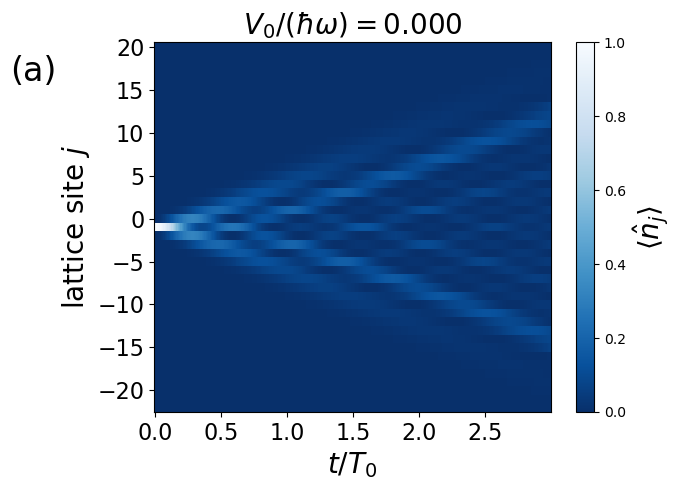

In [13]:
#############################################
# Part3: Particle propagation in 1D-lattice #
#############################################

n = 43
critical = 2.408

J2_J1 = 1
A_J1 = 0
V0_J1 = 0
hw_J1 = 20
Delta_J1 = 0.4

# Parameters in units of h/T_0 (h: Reduced Planck constant, T_0: Time period of undriven
# two site oscillations of local density for no drive and no imbalance)
j1 = np.pi
j2 = np.pi*J2_J1
a = np.pi*A_J1
wT = np.pi*hw_J1
v0 = 0*critical*wT
delta = np.pi*Delta_J1

ret1 = SEQ(j1,j2,a,v0,wT,phi=0,dt_T=0.01,cycles=3,start=0,s=1e-15,delta=delta,n=n)
t_T, density, hopping, consistency = ret1
m = len(t_T)

site = np.arange(-n//2,n//2,1)
t_T,site = np.meshgrid(t_T,site)


#fig, ax = plt.subplots()
fig = plt.figure()
plt.xlabel(r'$t/T_0$',fontsize=20)
plt.ylabel(r'lattice site $j$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.pcolormesh(t_T,site,density,cmap='Blues_r',shading='auto')#,norm=LogNorm(vmin=1e-4,vmax=1))
cbar = plt.colorbar()
cbar.set_label(r'$\langle\hat{n}_j\rangle$',fontsize=20)
#cbar.ax.tick_params(labelsize=16)
plt.title(r'$V_0/(\hbar\omega)=%.3f$' % (v0/wT),fontsize=20)
fig.text(-0.1,0.8,'(a)',fontsize=24)
#cbar.ax.set_title(label=r'$\langle\hat{n}_j\rangle$',size=20)
plt.show()

In [15]:
# Study time evolution of spatial standard deviation as function of driving parameters

# Define linear function for fitting
def lin_func(x,m,b):
    return m*x+b

# Calculates first moment
def mom1(n,ar):
    m = len(ar)
    m1 = 0
    for i in range(m):
        m1 += ar[i]*phys(n,i)
    return m1
   
# Calculates second moment
def mom2(n,ar):
    m = len(ar)
    m2 = 0
    for i in range(m):
        m2 += ar[i]*phys(n,i)**2
    return m2

# Calculates standard deviation
def sigma(n,ar):
    mom_1 = mom1(n,ar)
    mom_2 = mom2(n,ar)
    deviation = mom_2-mom_1**2
    return deviation

# Convert time to index
def conv_time(t):
    return int(t/wT)

# Parameter setup
J2_J1 = 1
A_J1 = 0
V0_J1 = 0
hw_J1 = 20

# Parameters in units of h/T_0 (h: Reduced Planck constant, T_0: Time period of undriven
# two site oscillations of local density for no drive and no imbalance)
j1 = np.pi
j2 = np.pi*J2_J1
a = np.pi*A_J1
wT = np.pi*hw_J1

# Resolve Bessel like dependency of effective hopping amplitude by calculating (linear) time evolution of
# spatial standard deviation for several values of driving parameters. By fitting a linear function, we can 
# (up to a constant scaling factor) extract the value of the effective hopping amplitude.
def Bessel(delta,n,j1=j1,j2=j2,a=a,wT=wT,cycles=3,dt_T=0.002):

    critical = 2.408
    v0_crit = critical*wT
    v0 = np.linspace(0,3*v0_crit,10)

    k = len(v0)
    params = np.zeros((k,2))
    results = np.zeros((k,int(cycles/dt_T)))
    est = np.array([0,0])

    for i in range(k):
        ret = SEQ(j1,j2,a,v0[i],wT,phi=0,dt_T=dt_T,cycles=3,start=0,s=1e-15,delta=delta,n=n)
        t_T, density, hopping, consistency = ret
        m = len(t_T)
        deviation = np.zeros(m)

        for j in range(m):
            deviation[j] = np.sqrt(sigma(n,density[:,j]))

        popt, pcov = optimize.curve_fit(lin_func,t_T,deviation,est)
        
        results[i,:] = deviation
        params[i,:] = popt
    
        print('%.1f%%' % ((i+1)/k*100))
    return t_T, v0/wT, results, params

print('Done!')

Done!


In [16]:
n = 43    # number of lattice sites taken into account

Delta1_J1 = 0
delta1 = np.pi*Delta1_J1
t_T, v0, results1, params1 = Bessel(delta1,n)

Delta2_J1 = 1
delta2 = np.pi*Delta2_J1
#t_T, v0, results2, params2 = Bessel(delta2,n)

Delta3_J1 = 2
delta3 = np.pi*Delta3_J1
#xt_T, v0, results3, params3 = Bessel(delta3,n)

# Saving data
'''
with open('ENTER FILEPATH HERE', 'w') as file:
    file.write('# One particle n site deviation with dt/T=%.5f, cycles=%.1f, J2/J1=%.1f,hw/J1=%.1f,A/J1=%.1f, Delta/J1=%.1f\n' % (dt_T, cycles, J2_J1, hw_J1, A_J1, Delta3_J1))
    file.write('# V0 / wT m / 1\n')
    for i in range(len(v0)):
        file.write('%s %s\n' % (v0[i], params3[i,0]))
'''

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


"\nwith open('ENTER FILEPATH HERE', 'w') as file:\n    file.write('# One particle n site deviation with dt/T=%.5f, cycles=%.1f, J2/J1=%.1f,hw/J1=%.1f,A/J1=%.1f, Delta/J1=%.1f\n' % (dt_T, cycles, J2_J1, hw_J1, A_J1, Delta3_J1))\n    file.write('# V0 / wT m / 1\n')\n    for i in range(len(v0)):\n        file.write('%s %s\n' % (v0[i], params3[i,0]))\n"

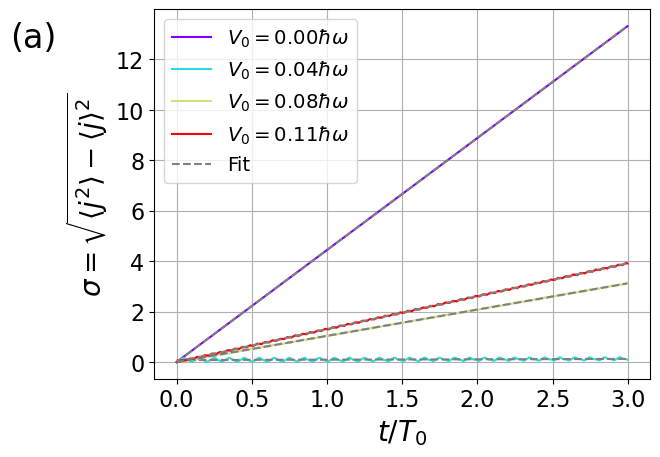

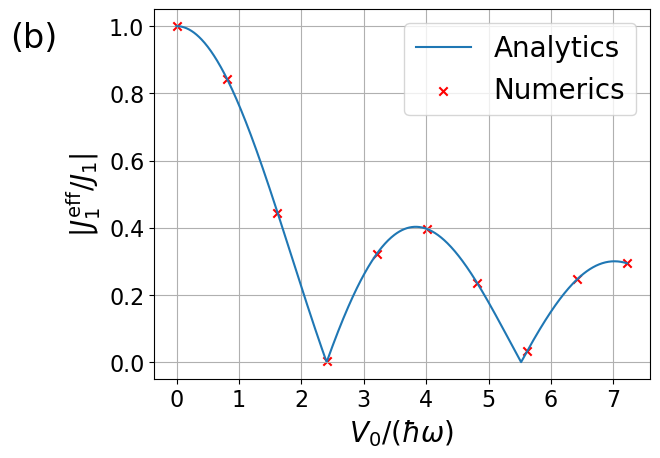

In [18]:
critical = 2.408
k = len(params1[:,0])
colors = cm.rainbow(np.linspace(0,1,k))

# Load locally stored data – if you need the data, just let me know!
'''
# load data for Delta1=0
data1 = np.loadtxt('../../Data_draft/OneParticle/DeviationD1_OneParticle.txt')
xdata1 = data1[:,0]
ydata1 = data1[:,1]
'''

# Plotting linear time evolution of standard deviation with line fits
fig = plt.figure()
plt.grid(True)
plt.xlabel(r'$t/T_0$', fontsize=20)
plt.ylabel(r'$\sigma=\sqrt{\langle j^2 \rangle - \langle j \rangle^2}$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

for i in range(0,k,3):
    plt.plot(t_T,results1[i,:],label=r'$V_0=%.2f\hbar\omega$' % (v0[i]/wT),c=colors[i])
    plt.plot(t_T,lin_func(t_T,*params1[i,:]),linestyle='--',alpha=1,c='grey')

plt.plot(np.NaN,np.NaN,linestyle='--',c='grey',label='Fit')
plt.legend(loc='best',fontsize=14.2)
fig.text(-0.1,0.8,'(a)',fontsize=24)
plt.show()

c1 = params1[0,0]
x = np.arange(0,v0[-1],0.01)

# Plotting dependency of effective hopping amplitude on the driving parameters
fig = plt.figure()
plt.grid()
plt.xlabel(r'$V_0/(\hbar\omega)$', fontsize=20)
plt.ylabel('$|J^\mathrm{eff}_1/J_1|$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(x,np.abs(jv(0,x)),label=r'Analytics')
plt.scatter(v0,params1[:,0]/c1,marker='x',label='Numerics',c='r')

plt.legend(loc='best',fontsize=20)
fig.text(-0.1,0.8,'(b)',fontsize=24)
plt.show()